<h1> Feature Engineering </h1>

In this notebook, you will learn how to incorporate feature engineering into your pipeline.
<ul>
<li> Working with feature columns </li>
<li> Adding feature crosses in TensorFlow </li>
<li> Reading data from BigQuery </li>
<li> Creating datasets using Dataflow </li>
<li> Using a wide-and-deep model </li>
</ul>

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. After that, run the following to ensure we've installed Beam.

In [1]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade apache-beam[gcp]

Solving environment: ...working... done

# All requested packages already installed.

Requirement already up-to-date: apache-beam[gcp] in /usr/local/envs/py2env/lib/python2.7/site-packages (2.6.0)




==> WARNING: A newer version of conda exists. <==
  current version: 4.5.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base -c defaults conda


Skipping google-cloud-dataflow as it is not installed.


After doing a pip install, you have to ```Reset Session``` so that the new packages are picked up.  Please click on the button in the above menu.

In [1]:
import tensorflow as tf
import apache_beam as beam
import shutil
print(tf.__version__)

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


<h2> 1. Environment variables for project and bucket </h2>

<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. Therefore, we should <b>create a single-region bucket</b>. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available) </li>
</ol>
<b>Change the cell below</b> to reflect your Project ID and bucket name.


In [2]:
import os
PROJECT = 'qwiklabs-gcp-872626494a3ab6c5'    # CHANGE THIS
BUCKET = 'qwiklabs-gcp-872626494a3ab6c5' # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
REGION = 'asia-south1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.

In [3]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8' 

## ensure we're using python2 env
os.environ['CLOUDSDK_PYTHON'] = 'python2'

In [4]:
%%bash
## ensure gcloud is up to date
gcloud components update

gcloud config set project $PROJECT
gcloud config set compute/region $REGION

## ensure we predict locally with our current Python environment
gcloud config set ml_engine/local_python `which python`


All components are up to date.
Updated property [core/project].
Updated property [compute/region].
Updated property [ml_engine/local_python].


<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [5]:
def create_query(phase, EVERY_N):
  if EVERY_N == None:
    EVERY_N = 4 #use full dataset
    
  #select and pre-process fields
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
  
  #add subsampling criteria by modding with hashkey
  if phase == 'train': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} < 2".format(base_query,EVERY_N)
  elif phase == 'valid': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 2".format(base_query,EVERY_N)
  elif phase == 'test':
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 3".format(base_query,EVERY_N)
  return query
    
print(create_query('valid', 100)) #example query using 1% of data


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100 == 2


Try the query above in https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips if you want to see what it does (ADD LIMIT 10 to the query!)

<h2> 3. Preprocessing Dataflow job from BigQuery </h2>

This code reads from BigQuery and saves the data as-is on Google Cloud Storage.  We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://www.tensorflow.org/api_docs/python/tf/contrib/cloud/BigQueryReader), it is quite convenient to export to CSV and do the training off CSV.  Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [6]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

In [7]:
import datetime

####
# Arguments:
#   -rowdict: Dictionary. The beam bigquery reader returns a PCollection in
#     which each row is represented as a python dictionary
# Returns:
#   -rowstring: a comma separated string representation of the record with dayofweek
#     converted from int to string (e.g. 3 --> Tue)
####
def to_csv(rowdict):
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  rowdict['dayofweek'] = days[rowdict['dayofweek']]
  rowstring = ','.join([str(rowdict[k]) for k in CSV_COLUMNS])
  return rowstring


####
# Arguments:
#   -EVERY_N: Integer. Sample one out of every N rows from the full dataset.
#     Larger values will yield smaller sample
#   -RUNNER: 'DirectRunner' or 'DataflowRunner'. Specfy to run the pipeline
#     locally or on Google Cloud respectively. 
# Side-effects:
#   -Creates and executes dataflow pipeline. 
#     See https://beam.apache.org/documentation/programming-guide/#creating-a-pipeline
####
def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print('Launching Dataflow job {} ... hang on'.format(job_name))
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)

  #dictionary of pipeline options
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'runner': RUNNER
  }
  #instantiate PipelineOptions object using options dictionary
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  #instantantiate Pipeline object using PipelineOptions
  with beam.Pipeline(options=opts) as p:
      for phase in ['train', 'valid']:
        query = create_query(phase, EVERY_N) 
        outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(phase))
        (
          p | 'read_{}'.format(phase) >> beam.io.Read(beam.io.BigQuerySource(query=query))
            | 'tocsv_{}'.format(phase) >> beam.Map(to_csv)
            | 'write_{}'.format(phase) >> beam.io.Write(beam.io.WriteToText(outfile))
        )
  print("Done")

Run pipeline locally. This takes upto <b>5 minutes</b>.  You will see a message "Done" when it is done.

In [8]:
preprocess(50*10000, 'DirectRunner') 

Launching Dataflow job preprocess-taxifeatures-180920-105456 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/runners/direct/direct_runner.py:342: DeprecationWarning: options is deprecated since First stable release.. References to <pipeline>.options will not be supported
  pipeline.replace_all(_get_transform_overrides(pipeline.options))
/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)


Done


In [9]:
%%bash
gsutil ls gs://$BUCKET/taxifare/ch4/taxi_preproc/

gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00001-of-00005
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00002-of-00005
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00003-of-00005
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00004-of-00005
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00002
gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/valid.csv-00001-of-00002


## 4. Run Beam pipeline on Cloud Dataflow

Run pipleline on cloud on a larger sample size.

In [10]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

The following step will take <b>15-20 minutes.</b> Monitor job progress on the [Cloud Console, in the Dataflow](https://console.cloud.google.com/dataflow) section

In [11]:
preprocess(50*100, 'DataflowRunner') 
#change first arg to None to preprocess full dataset

Launching Dataflow job preprocess-taxifeatures-180920-110059 ... hang on
Done


Once the job completes, observe the files created in Google Cloud Storage

In [12]:
%%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

   6042420  2018-09-20T11:07:35Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00004
    114336  2018-09-20T10:55:36Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005
   6163416  2018-09-20T11:07:35Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00001-of-00004
    114925  2018-09-20T10:55:36Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00001-of-00005
  12067262  2018-09-20T11:07:35Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00002-of-00004
    114723  2018-09-20T10:55:36Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00002-of-00005
  24395044  2018-09-20T11:07:35Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00003-of-00004
    108807  2018-09-20T10:55:36Z  gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00003-of-00005
    113890  2018-09-20T10:55:36Z  gs://q

In [13]:
%%bash
#print first 10 lines of first shard of train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

8.5,Fri,12,-73.978422,40.761883,-73.97829,40.783385,1.0,2011-12-16 12:19:00.000000-73.978440.761940.7834-73.9783
6.9,Fri,12,-73.97848,40.761923,-73.975068,40.751935,1.0,2011-12-16 12:19:00.000000-73.978540.761940.7519-73.9751
5.3,Fri,12,-73.979095,40.75028,-73.977833,40.744745,1.0,2011-12-16 12:19:00.000000-73.979140.750340.7447-73.9778
7.3,Fri,12,-73.979063,40.761318,-73.990082,40.750628,1.0,2011-12-16 12:19:00.000000-73.979140.761340.7506-73.9901
8.5,Fri,12,-73.980602,40.764458,-73.996707,40.752507,1.0,2011-12-16 12:19:00.000000-73.980640.764540.7525-73.9967
5.7,Fri,12,-73.981083,40.76531,-73.971748,40.761703,1.0,2011-12-16 12:19:00.000000-73.981140.765340.7617-73.9717
4.1,Fri,12,-73.981638,40.743713,-73.987442,40.7385,1.0,2011-12-16 12:19:00.000000-73.981640.743740.7385-73.9874
5.3,Fri,12,-73.981927,40.736247,-73.991667,40.73117,1.0,2011-12-16 12:19:00.000000-73.981940.736240.7312-73.9917
14.9,Fri,12,-73.982276,40.768294,-74.000627,40.728882,1.0,2011-12-16 12:19:00.000000-73.982340.

## 5. Develop model with new inputs

Download the first shard of the preprocessed data to enable local development.

In [14]:
%%bash
if [ -d sample ]; then
  rm -rf sample
fi
mkdir sample
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" > sample/train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" > sample/valid.csv

We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [15]:
%%bash
grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


In [16]:
%%bash
grep -A 50 "build_estimator" taxifare/trainer/model.py

def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, plat, plon, dlat, dlon, pcount, latdiff, londiff, euclidean) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.cr

In [17]:
%%bash
grep -A 15 "add_engineered(" taxifare/trainer/model.py

def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

--
    features = add_engineered(feature_placeholders.copy())
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = fea

Try out the new model on the local sample (this takes <b>5 minutes</b>) to make sure it works fine.

In [18]:
%%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
python -m trainer.task \
  --train_data_paths=${PWD}/sample/train.csv \
  --eval_data_paths=${PWD}/sample/valid.csv  \
  --output_dir=${PWD}/taxi_trained \
  --train_steps=10 \
  --job-dir=/tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 30, '_session_config': None, '_keep_checkpoint_max': 3, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd9522ab050>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/training-data-analyst/courses/machine_learning/feateng/taxi_trained/', '_global_id_in_cluster': 0, '_save_summary_steps':

In [19]:
%%bash
ls taxi_trained/export/exporter/

1537441851


You can use ```saved_model_cli``` to look at the exported signature. Note that the model doesn't need any of the engineered features as inputs. It will compute latdiff, londiff, euclidean from the provided inputs, thanks to the ```add_engineered``` call in the serving_input_fn.

In [20]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${PWD}/taxi_trained/export/exporter/${model_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dayofweek'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: Placeholder_5:0
    inputs['dropofflat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_2:0
    inputs['dropofflon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_3:0
    inputs['hourofday'] tensor_info:
        dtype: DT_INT32
        shape: (-1)
        name: Placeholder_6:0
    inputs['passengers'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_4:0
    inputs['pickuplat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder:0
    inputs['pickuplon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_1:0
  The given SavedModel SignatureDef contains the fo

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
%%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

Writing /tmp/test.json


In [22]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

PREDICTIONS
[-3.4673378467559814]


  from ._conv import register_converters as _register_converters
2018-09-20 11:10:59.555591: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA



## 5. Train on cloud

This will take <b> 10-15 minutes </b> even though the prompt immediately returns after the job is submitted. Monitor job progress on the [Cloud Console, in the ML Engine](https://console.cloud.google.com/mlengine) section and wait for the training job to complete.


In [23]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=BASIC \
  --runtime-version=$TFVERSION \
  -- \
  --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
  --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_trained asia-south1 lab4a_180920_111100


CommandException: 1 files/objects could not be removed.
ERROR: (gcloud.ml-engine.jobs.submit.training) INVALID_ARGUMENT: Field: region Error: The provided GCE region 'asia-south1' is not available. Options are [asia-east1, europe-west1, europe-west4, us-central1, us-east1, us-west1].
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The provided GCE region 'asia-south1' is not available. Options are
      [asia-east1, europe-west1, europe-west4, us-central1, us-east1, us-west1].
    field: region


The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

In [24]:
%bash
gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1

CommandException: One or more URLs matched no objects.


In [25]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${model_dir} --all

CommandException: One or more URLs matched no objects.
/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
usage: saved_model_cli show [-h] --dir DIR [--all] [--tag_set TAG_SET]
                            [--signature_def SIGNATURE_DEF_KEY]
saved_model_cli show: error: argument --dir: expected one argument


In [26]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
gcloud ml-engine local predict \
  --model-dir=${model_dir} \
  --json-instances=/tmp/test.json

CommandException: One or more URLs matched no objects.
ERROR: (gcloud.ml-engine.local.predict) /usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call last):
  File "lib/googlecloudsdk/command_lib/ml_engine/local_predict.py", line 172, in <module>
    main()
  File "lib/googlecloudsdk/command_lib/ml_engine/local_predict.py", line 167, in main
    signature_name=args.signature_name)
  File "/tools/google-cloud-sdk/lib/third_party/ml_sdk/cloud/ml/prediction/prediction_lib.py", line 104, in local_predict
    client = create_client(framework, model_dir, **kwargs)
  File "/tools/google-cloud-sdk/lib/third_party/ml_sdk/cloud/ml/prediction/prediction_lib.py", line 93, in create_client
    return create_client_

### Optional: deploy model to cloud

In [27]:
%%bash
MODEL_NAME="feateng"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Run these commands one-by-one (the very first time, you'll create a model and then create a version)


CommandException: One or more URLs matched no objects.
ERROR: (gcloud.ml-engine.models.create) INVALID_ARGUMENT: Field: model.regions Error: The provided GCE region 'asia-south1' is not available. Options are [asia-northeast1, europe-west1, us-central1, us-east1].
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The provided GCE region 'asia-south1' is not available. Options are
      [asia-northeast1, europe-west1, us-central1, us-east1].
    field: model.regions
ERROR: (gcloud.ml-engine.versions.create) argument --origin: expected one argument
Usage: gcloud ml-engine versions create VERSION --model=MODEL [optional flags]
  optional flags may be  --async | --config | --description | --framework |
                         --help | --labels | --origin | --python-version |
                         --runtime-version | --staging-bucket

For detailed information on this command and its flags, run:
  gcloud ml-engine versions create --help


In [28]:
%%bash
gcloud ml-engine predict --model=feateng --version=v1 --json-instances=/tmp/test.json

ERROR: (gcloud.ml-engine.predict) HTTP request failed. Response: {
  "error": {
    "code": 404,
    "message": "Field: name Error: The model resource: \"feateng\" was not found. Please create the Cloud ML model resource first by using 'gcloud ml-engine models create feateng'.",
    "status": "NOT_FOUND",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.BadRequest",
        "fieldViolations": [
          {
            "field": "name",
            "description": "The model resource: \"feateng\" was not found. Please create the Cloud ML model resource first by using 'gcloud ml-engine models create feateng'."
          }
        ]
      }
    ]
  }
}



<h2> 6. Hyper-parameter tune </h2>

Look at <a href="hyperparam.ipynb">hyper-parameter tuning notebook</a> to decide what parameters to use for model. Based on that run, I ended up choosing:
<ol>
<li> train_batch_size: 512 </li>
<li> nbuckets: 16 </li>
<li> hidden_units: "64 64 64 8" </li>    
</ol>

This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over a larger dataset.

# Optional: Run Cloud training on 2 million row dataset

This run uses as input 2 million rows and takes ~20 minutes with 10 workers (STANDARD_1 pricing tier). The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC). Because the Dataflow preprocessing takes about 15 minutes, we train here using CSV files in a public bucket.

When doing distributed training, use train_steps instead of num_epochs. The distributed workers don't know how many rows there are, but we can calculate train_steps = num_rows \* num_epochs / train_batch_size. In this case, we have 2141023 * 100 / 512 = 418168 train steps.

In [29]:
%%bash

WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://${BUCKET}/taxifare/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/feateng2m asia-south1 lab4a_180920_121637


bash: line 2: WARNING: command not found
CommandException: 1 files/objects could not be removed.
ERROR: (gcloud.ml-engine.jobs.submit.training) INVALID_ARGUMENT: Field: region Error: The provided GCE region 'asia-south1' is not available. Options are [asia-east1, europe-west1, europe-west4, us-central1, us-east1, us-west1].
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The provided GCE region 'asia-south1' is not available. Options are
      [asia-east1, europe-west1, europe-west4, us-central1, us-east1, us-west1].
    field: region


### Start Tensorboard

In [34]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print(OUTDIR)
TensorBoard().start(OUTDIR)

gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/feateng2m


TensorBoard was started successfully with pid 8321. Click here to access it.

8321

### Stop Tensorboard

In [31]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 8069


The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

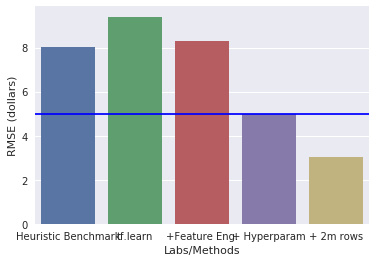

In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

In [33]:
%%bash
gsutil -m mv gs://${BUCKET}/taxifare/ch4/ gs://${BUCKET}/taxifare/ch4_1m/

Copying gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180920-110059.1537441260.255431/apache_beam-2.6.0-cp27-cp27mu-manylinux1_x86_64.whl [Content-Type=application/octet-stream]...
Copying gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180920-110059.1537441260.255431/dataflow_python_sdk.tar [Content-Type=application/octet-stream]...
Copying gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005 [Content-Type=text/plain]...
Copying gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180920-110059.1537441260.255431/pipeline.pb [Content-Type=application/octet-stream]...
Copying gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00004 [Content-Type=text/plain]...
Removing gs://qwiklabs-gcp-872626494a3ab6c5/taxifare/ch4/taxi_preproc/train.csv-00000-of-00004...
Removing gs://qwiklabs-gcp-8

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License

In [36]:
a = np.linspace(32.0,42,5)
a

array([32. , 34.5, 37. , 39.5, 42. ])